## Load google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install required libs

In [2]:
!pip install -U "tensorflow-text==2.13.*"
import tensorflow_text as text

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 50.9 MB/s eta 0:00:00


In [3]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras
import matplotlib.pyplot as plt

from wordcloud import WordCloud
from math import log, sqrt, exp
import pandas as pd
import numpy as np
from numpy import sign

import re
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import nltk
nltk.download('punkt')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import WordPunctTokenizer
tok = WordPunctTokenizer()

from keras import optimizers
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv1D, Dense, Input, LSTM, Embedding, Dropout, Activation, MaxPooling1D, Bidirectional, SimpleRNN
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
"""
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('fivethirtyeight')
"""

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


"\n%matplotlib inline\n%config InlineBackend.figure_format = 'retina'\nplt.style.use('fivethirtyeight')\n"

## Change to diploma directory

In [5]:
import os
os.chdir('/content/drive/MyDrive/data_twitter')

# Load and prepare data

## Read data

In [8]:
df_train = pd.read_csv('df_train.csv')
df_val   = pd.read_csv('df_val.csv')
df_test  = pd.read_csv('df_test.csv')

len(df_train), len(df_val), len(df_test)

(48503, 10395, 10393)

In [9]:
df_train.head(3)

,Unnamed: 0,Text,Sentiment
0,0,just finished my second exam only one more to go,0.0
1,1,i was so much happier in prison ever since i c...,3.0
2,2,can depression be cured by positivity anxiety ...,3.0


Concatenate data

In [10]:
df = pd.concat([df_train, df_val, df_test], ignore_index=True)


## Tokenize

In [11]:
from nltk.tokenize import TweetTokenizer
tk = TweetTokenizer(reduce_len=True)

In [12]:
from nltk.tokenize import TweetTokenizer


tk = TweetTokenizer(reduce_len=True)

data = []

X = df['Text'].tolist()
Y = df['Sentiment'].tolist()

for x, y in zip(X, Y):
  data.append((tk.tokenize(x), int(y)))

data[:2]

[(['just',
   'finished',
   'my',
   'second',
   'exam',
   'only',
   'one',
   'more',
   'to',
   'go'],
  0),
 (['i',
   'was',
   'so',
   'much',
   'happier',
   'in',
   'prison',
   'ever',
   'since',
   'i',
   'came',
   'home',
   'mlife',
   'slowly',
   'fell',
   'apart',
   'im',
   'left',
   'with',
   'depression',
   'and',
   'severe',
   'dpdr',
   'i',
   'actually',
   'wish',
   'i',
   'was',
   'who',
   'i',
   'was',
   'in',
   'prison',
   'riddle',
   'me',
   'thatwtf'],
  3)]

## Preprocess data

In [13]:
import re, string

import nltk
from nltk.tag import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('wordnet')
STOP_WORDS = stopwords.words('english')

def cleaned(token):
    if token == 'u':
        return 'you'
    if token == 'r':
        return 'are'
    if token == 'some1':
        return 'someone'
    if token == 'yrs':
        return 'years'
    if token == 'hrs':
        return 'hours'
    if token == 'mins':
        return 'minutes'
    if token == 'secs':
        return 'seconds'
    if token == 'pls' or token == 'plz':
        return 'please'
    if token == '2morow' or token == '2moro':
        return 'tomorrow'
    if token == '2day':
        return 'today'
    if token == '4got' or token == '4gotten':
        return 'forget'
    if token in ['hahah', 'hahaha', 'hahahaha']:
        return 'haha'
    if token == "mother's":
        return "mother"
    if token == "mom's":
        return "mom"
    if token == "dad's":
        return "dad"
    if token == 'bday' or token == 'b-day':
        return 'birthday'
    if token in ["i'm", "don't", "can't", "couldn't", "aren't", "wouldn't", "isn't", "didn't", "hadn't","doesn't", "won't", "haven't", "wasn't", "hasn't", "shouldn't", "ain't", "they've"]:
        return token.replace("'", "")
    if token in ['lmao', 'lolz', 'rofl']:
        return 'lol'
    if token == '<3':
        return 'love'
    if token == 'thanx' or token == 'thnx' or token == "thnks":
        return 'thanks'
    if token == 'goood':
        return 'good'
    if token in ['amp', 'quot', 'lt', 'gt', '½25', '..', '. .', '. . .']:
        return ''
    return token



def remove_noise(tweet_tokens):

    cleaned_tokens = []

    for token in tweet_tokens:

        token = re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", token)

        token = re.sub("(@[A-Za-z0-9_]+)","", token)

        cleaned_token = cleaned(token.lower())

        if cleaned_token == "idk":
            cleaned_tokens.append('i')
            cleaned_tokens.append('dont')
            cleaned_tokens.append('know')
            continue
        if cleaned_token == "i'll":
            cleaned_tokens.append('i')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "you'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "we'll":
            cleaned_tokens.append('we')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it'll":
            cleaned_tokens.append('it')
            cleaned_tokens.append('will')
            continue
        if cleaned_token == "it's":
            cleaned_tokens.append('it')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i've":
            cleaned_tokens.append('i')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you've":
            cleaned_tokens.append('you')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "we've":
            cleaned_tokens.append('we')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "they've":
            cleaned_tokens.append('they')
            cleaned_tokens.append('have')
            continue
        if cleaned_token == "you're":
            cleaned_tokens.append('you')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "we're":
            cleaned_tokens.append('we')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "they're":
            cleaned_tokens.append('they')
            cleaned_tokens.append('are')
            continue
        if cleaned_token == "let's":
            cleaned_tokens.append('let')
            cleaned_tokens.append('us')
            continue
        if cleaned_token == "she's":
            cleaned_tokens.append('she')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "he's":
            cleaned_tokens.append('he')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "that's":
            cleaned_tokens.append('that')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "i'd":
            cleaned_tokens.append('i')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "you'd":
            cleaned_tokens.append('you')
            cleaned_tokens.append('would')
            continue
        if cleaned_token == "there's":
            cleaned_tokens.append('there')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "what's":
            cleaned_tokens.append('what')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "how's":
            cleaned_tokens.append('how')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "who's":
            cleaned_tokens.append('who')
            cleaned_tokens.append('is')
            continue
        if cleaned_token == "y'all" or cleaned_token == "ya'll":
            cleaned_tokens.append('you')
            cleaned_tokens.append('all')
            continue

        if cleaned_token.strip() and cleaned_token not in string.punctuation and len(cleaned_token)>2 and cleaned_token not in STOP_WORDS:
            cleaned_tokens.append(cleaned_token)
    return cleaned_tokens




def read_glove_vecs(glove_file):
    with open(glove_file, 'r', encoding="utf8") as f:
        words = set()
        word_to_vec_map = {}
        for line in f:
            line = line.strip().split()
            curr_word = line[0]
            words.add(curr_word)
            word_to_vec_map[curr_word] = np.array(line[1:], dtype=np.float64)

        i = 1
        words_to_index = {}
        index_to_words = {}
        for w in sorted(words):
            words_to_index[w] = i
            index_to_words[i] = w
            i = i + 1
    return words_to_index, index_to_words, word_to_vec_map
    return cleaned_tokens


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [14]:
print(remove_noise(data[0][0]))

['finished', 'second', 'exam', 'one']


## Embedding matrix

In [17]:
word_to_index, index_to_word, word_to_vec_map = read_glove_vecs('/content/drive/MyDrive/data_twitter/glove.6B.300d.txt')
word_to_vec_map['hello']

array([-3.3712e-01, -2.1691e-01, -6.6365e-03, -4.1625e-01, -1.2555e+00,
       -2.8466e-02, -7.2195e-01, -5.2887e-01,  7.2085e-03,  3.1997e-01,
        2.9425e-02, -1.3236e-02,  4.3511e-01,  2.5716e-01,  3.8995e-01,
       -1.1968e-01,  1.5035e-01,  4.4762e-01,  2.8407e-01,  4.9339e-01,
        6.2826e-01,  2.2888e-01, -4.0385e-01,  2.7364e-02,  7.3679e-03,
        1.3995e-01,  2.3346e-01,  6.8122e-02,  4.8422e-01, -1.9578e-02,
       -5.4751e-01, -5.4983e-01, -3.4091e-02,  8.0017e-03, -4.3065e-01,
       -1.8969e-02, -8.5670e-02, -8.1123e-01, -2.1080e-01,  3.7784e-01,
       -3.5046e-01,  1.3684e-01, -5.5661e-01,  1.6835e-01, -2.2952e-01,
       -1.6184e-01,  6.7345e-01, -4.6597e-01, -3.1834e-02, -2.6037e-01,
       -1.7797e-01,  1.9436e-02,  1.0727e-01,  6.6534e-01, -3.4836e-01,
        4.7833e-02,  1.6440e-01,  1.4088e-01,  1.9204e-01, -3.5009e-01,
        2.6236e-01,  1.7626e-01, -3.1367e-01,  1.1709e-01,  2.0378e-01,
        6.1775e-01,  4.9075e-01, -7.5210e-02, -1.1815e-01,  1.86

In [18]:
unks = []
UNKS = []

def cleared(word):
    res = ""
    prev = None
    for char in word:
        if char == prev: continue
        prev = char
        res += char
    return res

def sentence_to_indices(sentence_words, word_to_index, max_len, i):
    global X, Y
    sentence_indices = []
    for j, w in enumerate(sentence_words):
        try:
            index = word_to_index[w]
        except:
            UNKS.append(w)
            w = cleared(w)
            try:
                index = word_to_index[w]
            except:
                index = word_to_index['unk']
                unks.append(w)
        X[i, j] = index

cleaned_tokens_list = []

for tokens, label in data:
    x = remove_noise(tokens)
    if x:
        cleaned_tokens_list.append((x, label))

list_len = [len(i) for i, j in cleaned_tokens_list]
max_len = max(list_len)
print('max_len:', max_len)

X = np.zeros((len(cleaned_tokens_list), max_len))
Y = np.zeros((len(cleaned_tokens_list), ))

for i, tk_lb in enumerate(cleaned_tokens_list):
    tokens, label = tk_lb
    sentence_to_indices(tokens, word_to_index, max_len, i)
    Y[i] = label

print(X[:5])
print(Y[:5])

max_len: 2184
[[148534. 323025. 142268. ...      0.      0.      0.]
 [251645. 173071. 292520. ...      0.      0.      0.]
 [121306. 113859. 289395. ...      0.      0.      0.]
 [384337. 351990. 121306. ...      0.      0.      0.]
 [372306. 169754. 178764. ...      0.      0.      0.]]
[0. 3. 3. 2. 0.]


## Embeding layer

In [19]:
def pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len):
    vocab_len = len(word_to_index) + 1
    emb_dim = word_to_vec_map["unk"].shape[0]

    emb_matrix = np.zeros((vocab_len, emb_dim))

    for word, idx in word_to_index.items():
        emb_matrix[idx, :] = word_to_vec_map[word]

    embedding_layer = Embedding(vocab_len, emb_dim, trainable=False, input_shape=(max_len,))
    embedding_layer.build((None,))
    embedding_layer.set_weights([emb_matrix])

    return embedding_layer

## Split data

As splited by the author

In [20]:
from keras.utils import to_categorical
# (48503, 10395, 10393)
X_train = X[:48503]
y_train = to_categorical(Y[:48503])

X_val   = X[48503:58898]
y_val   = to_categorical(Y[48503:58898])

X_test  = X[58898:]
y_test  = to_categorical(Y[58898:])

We can use also train_test_split method

In [21]:
"""
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(X, to_categorical(Y), test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2
"""

'\nfrom keras.utils import to_categorical\nfrom sklearn.model_selection import train_test_split\n\n\nX_train, X_test, y_train, y_test = train_test_split(X, to_categorical(Y), test_size=0.2, random_state=1)\nX_train, X_val, y_train, y_val   = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2\n'

In [22]:
y_test

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.]], dtype=float32)

# Models

## Conv + LSTM

In [23]:
def build_model():
  model = Sequential()

  model.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))

  model.add(Conv1D(filters=32,
                           kernel_size=3,
                           padding='same',
                           strides = 1,
                           activation='relu'))

  model.add(MaxPooling1D(pool_size=2))

  model.add(Dropout(0.5))

  model.add(LSTM(units = 40,
                         activation="tanh",
                         recurrent_activation="sigmoid",
                         use_bias=True))

  model.add(Dropout(0.5))

  model.add(Dense(units = 4,
                          activation='softmax',
                          use_bias=True,
                          bias_initializer='zeros'))

  return model

In [24]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 2184, 300)         120000300 
                                                                 
 conv1d (Conv1D)             (None, 2184, 32)          28832     
                                                                 
 max_pooling1d (MaxPooling1  (None, 1092, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 1092, 32)          0         
                                                                 
 lstm (LSTM)                 (None, 40)                11680     
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                        

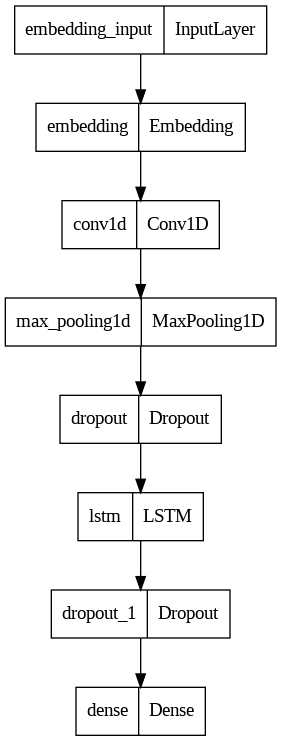

In [25]:
tf.keras.utils.plot_model(model)

In [ ]:
pip install "tf-models-official==2.13.*"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 40.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 21.7 MB/s eta 0:00:00
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=e1d1249fb253cedea2b7837cc354e15c3add4e0fc6556da67d473584167790df
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
from official.nlp import optimization
"""nadam = optimizers.Nadam(lr=0.0001,
                         beta_1=0.9,
                         beta_2=0.999,
                         epsilon=1e-8,
                         schedule_decay=0.004)"""
model.compile(loss='categorical_crossentropy',
              optimizer='nadam',
              metrics=['acc'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                           patience=3)
history = model.fit(X_train, y_train,
                    validation_data=[X_val, y_val],
                    epochs = 20,
                    batch_size = 128,
                    shuffle=True)

Epoch 1/20
379/379 [==============================] - 44s 67ms/step - loss: 1.1822 - acc: 0.4061 - val_loss: 1.1599 - val_acc: 0.4118
Epoch 2/20
379/379 [==============================] - 24s 64ms/step - loss: 1.1671 - acc: 0.4064 - val_loss: 1.1593 - val_acc: 0.3952
Epoch 3/20
379/379 [==============================] - 26s 67ms/step - loss: 1.1655 - acc: 0.4063 - val_loss: 1.1595 - val_acc: 0.3952
Epoch 4/20
379/379 [==============================] - 24s 62ms/step - loss: 1.1644 - acc: 0.4114 - val_loss: 1.1590 - val_acc: 0.4118
Epoch 5/20
379/379 [==============================] - 24s 63ms/step - loss: 1.1635 - acc: 0.4052 - val_loss: 1.1590 - val_acc: 0.4118
Epoch 6/20
379/379 [==============================] - 25s 67ms/step - loss: 1.1627 - acc: 0.4094 - val_loss: 1.1590 - val_acc: 0.4118
Epoch 7/20
379/379 [==============================] - 24s 64ms/step - loss: 1.1629 - acc: 0.4104 - val_loss: 1.1598 - val_acc: 0.4118
Epoch 8/20
379/379 [==============================] - 24s 64ms

In [ ]:
model.evaluate(X_test, y_test)

323/323 [==============================] - 5s 15ms/step - loss: 1.1679 - acc: 0.4161


[1.1679250001907349, 0.41606900095939636]

(0.0, 2.0)

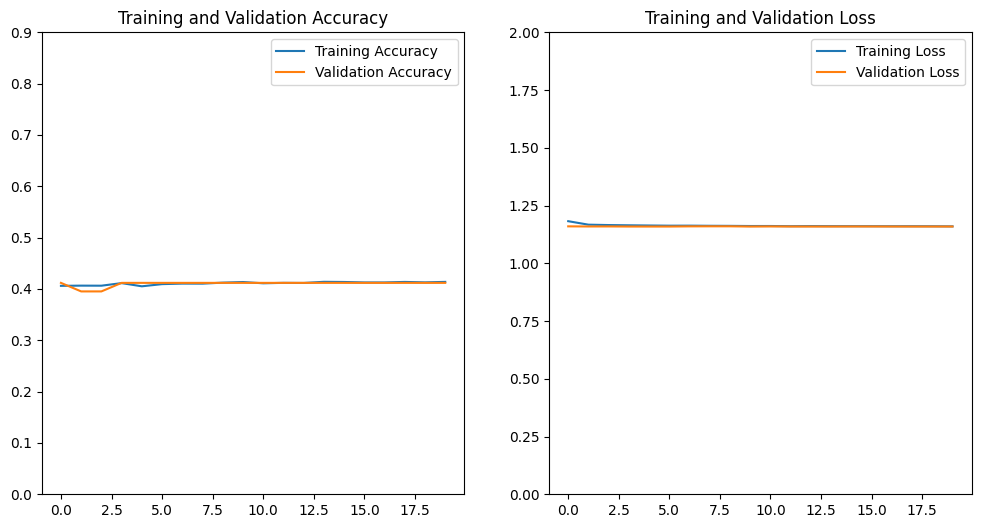

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.ylim(0,0.9)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim(0,2)

<font color='red'>accuracy: 0.41</font>

## LSTM

In [26]:
def make_model():
  model = Sequential()
  model.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
  model.add(LSTM(units=16, return_sequences=False))
  model.add(Dropout(0.5))
  model.add(Dense(units=4, activation='softmax'))

  return model

model = make_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 2184, 300)         120000300 
                                                                 
 lstm_1 (LSTM)               (None, 16)                20288     
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 120020656 (457.84 MB)
Trainable params: 20356 (79.52 KB)
Non-trainable params: 120000300 (457.76 MB)
_________________________________________________________________


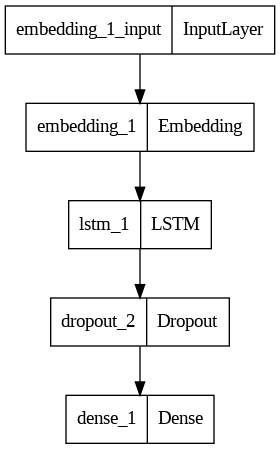

In [27]:
tf.keras.utils.plot_model(model)

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['acc'])

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs = 20, batch_size = 128, shuffle=True, callbacks = [early_stop])

Epoch 1/20
379/379 [==============================] - 33s 78ms/step - loss: 1.2024 - acc: 0.4047 - val_loss: 1.1620 - val_acc: 0.4118
Epoch 2/20
379/379 [==============================] - 27s 72ms/step - loss: 1.1743 - acc: 0.4065 - val_loss: 1.1594 - val_acc: 0.4118
Epoch 3/20
379/379 [==============================] - 28s 73ms/step - loss: 1.1677 - acc: 0.4091 - val_loss: 1.1594 - val_acc: 0.4118
Epoch 4/20
379/379 [==============================] - 28s 74ms/step - loss: 1.1653 - acc: 0.4086 - val_loss: 1.1593 - val_acc: 0.4118
Epoch 5/20
379/379 [==============================] - 27s 70ms/step - loss: 1.1647 - acc: 0.4087 - val_loss: 1.1591 - val_acc: 0.4118
Epoch 6/20
379/379 [==============================] - 27s 70ms/step - loss: 1.1634 - acc: 0.4129 - val_loss: 1.1591 - val_acc: 0.4118
Epoch 7/20
379/379 [==============================] - 27s 72ms/step - loss: 1.1622 - acc: 0.4107 - val_loss: 1.1595 - val_acc: 0.4118
Epoch 8/20
379/379 [==============================] - 27s 72ms

In [ ]:
model.evaluate(X_test, y_test)

323/323 [==============================] - 9s 28ms/step - loss: 1.1682 - acc: 0.4161


[1.16815185546875, 0.41606900095939636]

(0.0, 2.0)

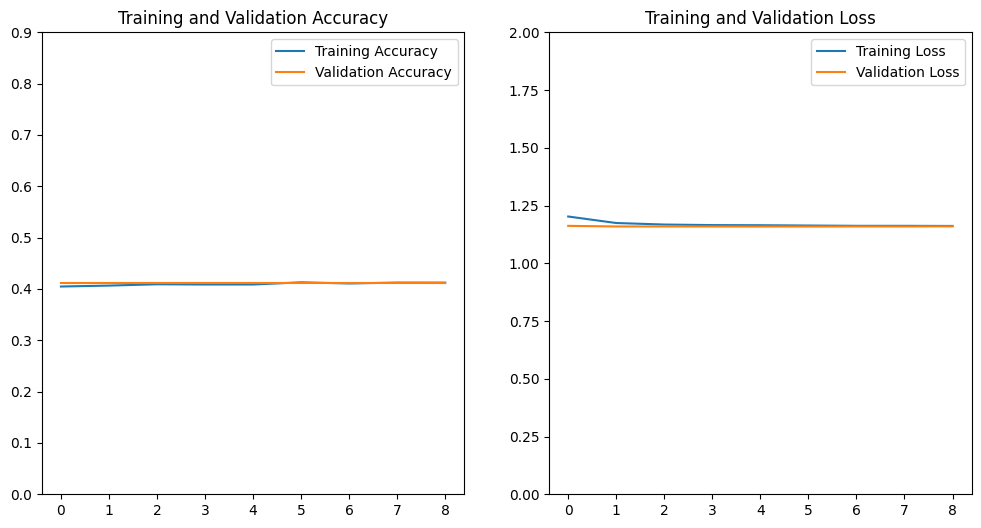

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.ylim(0,0.9)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim(0,2)

<font color='red'>accuracy: 0.416</font>

## RNN

<font color='red'>This part of script takes so much time ()</font>

In [28]:
def make_model():
  model = Sequential()
  model.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
  model.add(SimpleRNN(units=64))
  model.add(Dropout(0.5))
  model.add(Dense(units=4, activation='softmax'))

  return model
model = make_model()
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 2184, 300)         120000300 
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                23360     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 4)                 260       
                                                                 
Total params: 120023920 (457.85 MB)
Trainable params: 23620 (92.27 KB)
Non-trainable params: 120000300 (457.76 MB)
_________________________________________________________________


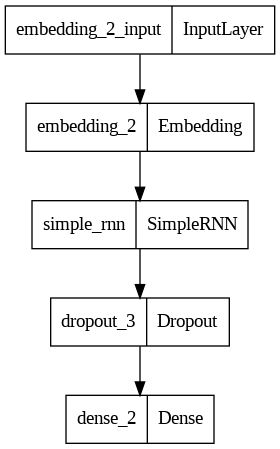

In [29]:
tf.keras.utils.plot_model(model)

In [30]:
model.compile(loss='categorical_crossentropy',
              optimizer="nadam",
              metrics=['acc'])

In [32]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs = 20,
                    batch_size = 128,
                    shuffle=True,
                    callbacks = [early_stop])

Epoch 1/20
 12/379 [..............................] - ETA: 6:23 - loss: 1.2411 - acc: 0.4010

KeyboardInterrupt: ignored

In [ ]:
model.evaluate(X_test, y_test)

323/323 [==============================] - 59s 184ms/step - loss: 1.1683 - acc: 0.4161


[1.1682790517807007, 0.41606900095939636]

In [ ]:
y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred.argmax(axis=1)))

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.ylim(0,0.9)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim(0,2)

<font color='red'>accuracy: 0.4161</font>

# GRID SEARCH CV

In [ ]:
!pip install scikeras

In [ ]:
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import  KerasClassifier
from sklearn.model_selection import cross_val_score
from tensorflow.keras.callbacks import EarlyStopping
def mmodel(optimizer):
  model = Sequential()
  model.add(pretrained_embedding_layer(word_to_vec_map, word_to_index, max_len))
  model.add(LSTM(units=16, return_sequences=False))
  model.add(Dropout(0.5))
  model.add(Dense(units=4, activation='softmax'))
  model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
  return model
model_gd=KerasClassifier(build_fn=mmodel)
param={"epochs":[16,30,50,100,500], "batch_size":[32,40,60,100],"optimizer":["adam","nadam"]}
grid_search=GridSearchCV(estimator=model_gd,param_grid=param,scoring='accuracy',cv=10)

ModuleNotFoundError: ignored

In [ ]:
best_param=grid_search.best_params_
best_param

In [ ]:
best_precision=grid_search.best_score_
best_precision

# Testing pretrained models

## Prepare df dataframe

In [ ]:
df = df.drop(columns=[col for col in df.columns if (col != 'Text' and col != 'Sentiment')])

df['Sentiment'] = df['Sentiment'].astype(int)

df.head(2)

,Text,Sentiment
0,just finished my second exam only one more to go,0
1,i was so much happier in prison ever since i c...,3


### Convert to numpy to create a dataset later, Dataset object help us to better manage RAM

In [ ]:
from keras.utils import to_categorical

X = df['Text'].to_numpy()
y = df['Sentiment'].to_numpy()
y = to_categorical(y)


In [ ]:
X, y

(array(['just finished my second exam only one more to go ',
        'i was so much happier in prison ever since i came home mlife slowly fell apart im left with depression and severe dpdr i actually wish i was who i was in prison riddle me thatwtf',
        'can depression be cured by positivity anxiety since  depression came at  and now i am  just had a thought is it possible for some of us that depression is just negativity thinking  and that positivity can cure or seem to cure us  surely brain training and looking at things in a positive perspective can help us ',
        ...,
        ' you know there are starving artists in ohio who have no breakfast burritos  ',
        'subsero ill be calling u   oh really take cover ',
        'just cleaned my balcony for the summer wow its much better now but where have all the flowers gone  must get new ones'],
       dtype=object),
 array([[1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 1.,

### Create datasets and batch each one

In [ ]:
#  (48503, 10395, 10393)
train_ds = tf.data.Dataset.from_tensor_slices((X[:48503],y[:48503])).batch(batch_size=32)
val_ds   = tf.data.Dataset.from_tensor_slices((X[48503:58898],y[48503:58898])).batch(batch_size=32)
test_ds  = tf.data.Dataset.from_tensor_slices((X[58898:],y[58898:])).batch(batch_size=32)


In [ ]:
del X,y

In [ ]:
text, sentiment = next(iter(train_ds))
text, sentiment

(<tf.Tensor: shape=(32,), dtype=string, numpy=
 array([b'just finished my second exam only one more to go ',
        b'i was so much happier in prison ever since i came home mlife slowly fell apart im left with depression and severe dpdr i actually wish i was who i was in prison riddle me thatwtf',
        b'can depression be cured by positivity anxiety since  depression came at  and now i am  just had a thought is it possible for some of us that depression is just negativity thinking  and that positivity can cure or seem to cure us  surely brain training and looking at things in a positive perspective can help us ',
        b'rt  ur wcw takes  depression naps a day worries about nothing and eats everything in sight its me im ur wcw',
        b'reeselasher you guys are hilarious why not just do a webseries since theyre the next big thing will also help promote amy ',
        b'thewiselemonpie is it broken i suddenly cant get facebook to update via twitter any more ',
        b'is so si

## Nnlm-en-50


In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True)
hub_layer(text[:2])


<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 0.27298903,  0.07571432, -0.0303079 ,  0.24995725, -0.07151183,
         0.12280701,  0.28551435, -0.09386962, -0.21852951, -0.03141751,
         0.18584445,  0.17050068,  0.16080476, -0.00520876,  0.33707377,
        -0.2919496 , -0.09920003,  0.15344825,  0.10717523, -0.46585366,
        -0.06841792,  0.10321502,  0.04499479, -0.03187961,  0.39644653,
        -0.04564101, -0.25304443, -0.03481478, -0.07956417, -0.09372799,
         0.07593235,  0.33681497,  0.3267701 , -0.3154874 , -0.11827763,
         0.07462682, -0.14261308, -0.04756982,  0.39252627, -0.33647853,
         0.11392823, -0.08895363,  0.03636975, -0.04450662, -0.31964758,
        -0.32639456, -0.1176049 , -0.31980973,  0.42254743,  0.15446408],
       [ 0.27993685, -0.20845199, -0.29800078,  0.1127215 ,  0.22452028,
        -0.0384354 ,  0.38607064, -0.09357059,  0.00331139,  0.06569882,
         0.12515485,  0.31271338,  0.17706336,  0.20065135, -0.1383306 ,
 

### Build model

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(4, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_2 (Dense)             (None, 16)                816       
                                                                 
 dense_3 (Dense)             (None, 4)                 68        
                                                                 
Total params: 48,191,484
Trainable params: 48,191,484
Non-trainable params: 0
_________________________________________________________________


### Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=20)

Epoch 1/20
1516/1516 [==============================] - 116s 76ms/step - loss: 0.6428 - accuracy: 0.7200 - val_loss: 0.5191 - val_accuracy: 0.7679
Epoch 2/20
1516/1516 [==============================] - 28s 18ms/step - loss: 0.4241 - accuracy: 0.8193 - val_loss: 0.5267 - val_accuracy: 0.7641
Epoch 3/20
1516/1516 [==============================] - 27s 18ms/step - loss: 0.3416 - accuracy: 0.8588 - val_loss: 0.5709 - val_accuracy: 0.7577
Epoch 4/20
1516/1516 [==============================] - 27s 18ms/step - loss: 0.2807 - accuracy: 0.8872 - val_loss: 0.6345 - val_accuracy: 0.7494
Epoch 5/20
1516/1516 [==============================] - 29s 19ms/step - loss: 0.2303 - accuracy: 0.9099 - val_loss: 0.7146 - val_accuracy: 0.7418
Epoch 6/20
1516/1516 [==============================] - 29s 19ms/step - loss: 0.1861 - accuracy: 0.9292 - val_loss: 0.8133 - val_accuracy: 0.7362
Epoch 7/20
1516/1516 [==============================] - 31s 20ms/step - loss: 0.1474 - accuracy: 0.9456 - val_loss: 0.9343 

In [ ]:
model.evaluate(test_ds)

325/325 [==============================] - 2s 5ms/step - loss: 2.7102 - accuracy: 0.7076


[2.710155963897705, 0.7075916528701782]

In [ ]:
results = model.evaluate(test_ds, verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.4f" % (name, value))

325/325 - 1s - loss: 2.7102 - accuracy: 0.7076 - 1s/epoch - 4ms/step
loss: 2.7102
accuracy: 0.7076


Text(0.5, 1.0, 'Training and Validation Loss')

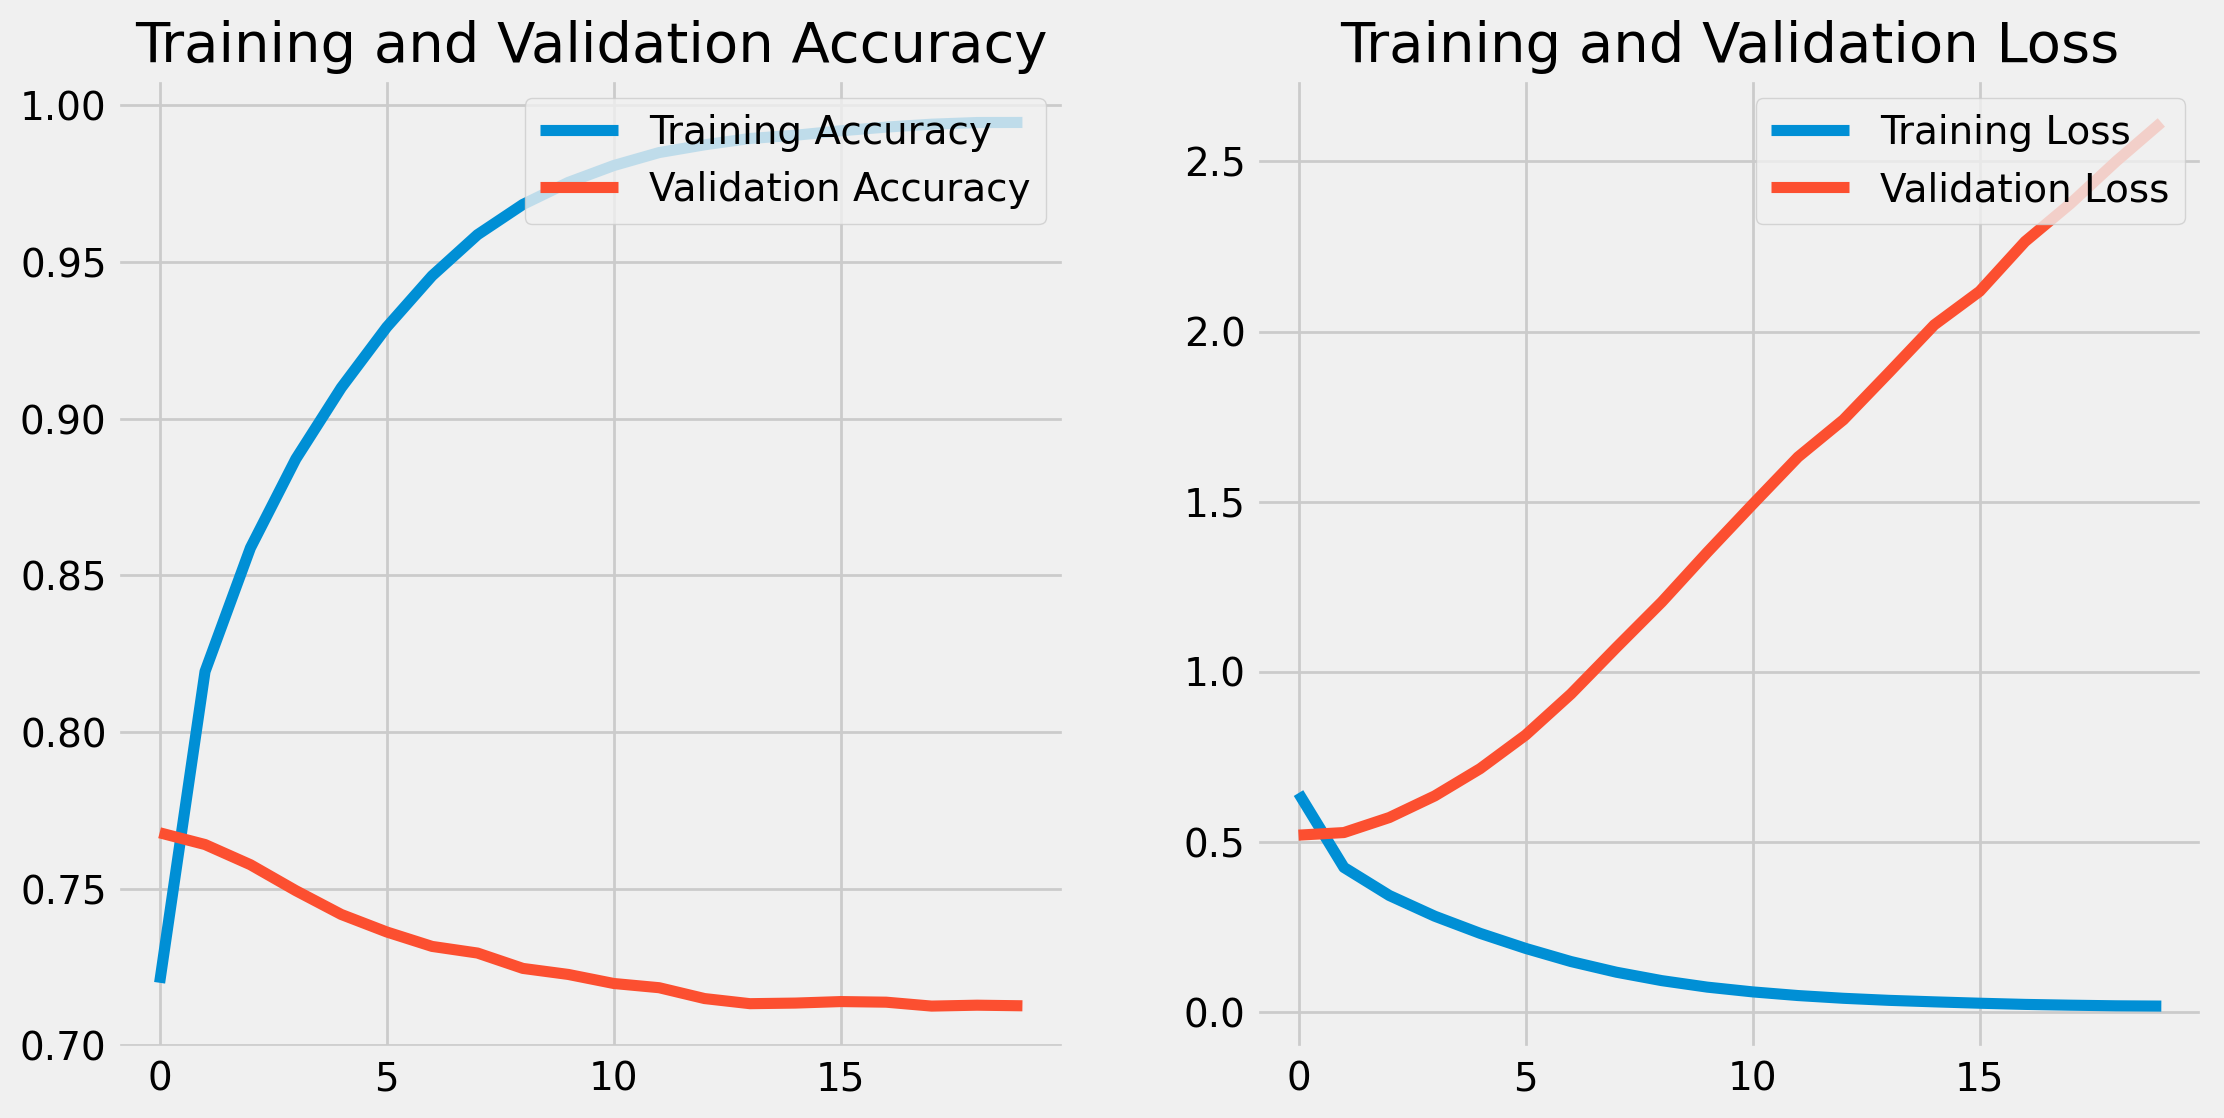

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
#plt.ylim(0,0.9)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
#plt.ylim(0,0.9)

## Bert

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=True)
hub_layer(text[:2])


### List of available pretrained bert model
Je commence à utiliser le simple appelé : small_bert <br>
La suggestion est de commencer par un petit BERT (avec moins de paramètres) car ils sont plus rapides à affiner. Si vous aimez un petit modèle mais avec une plus grande précision, ALBERT peut être utilisé. Si vous souhaitez une précision encore meilleure, choisissez l'une des tailles BERT classiques ou leurs améliorations récentes comme Electra, Talking Heads ou un BERT Expert.
pour plus d'informations:<br> https://www.tensorflow.org/text/tutorials/classify_text_with_bert#loading_models_from_tensorflow_hub

In [ ]:
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')


BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [ ]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

text_test = ['using tweets for sentiment detection!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')


Keys       : ['input_mask', 'input_word_ids', 'input_type_ids']
Shape      : (1, 128)
Word Ids   : [  101  2478  1056 28394  3215  2005 15792 10788   999   102     0     0]
Input Mask : [1 1 1 1 1 1 1 1 1 1 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


In [ ]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)


bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')


Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.9902758   0.9488596  -0.57447565  0.2359788   0.21087882  0.72540236
  0.99133396 -0.9693253  -0.45574492 -0.99491817 -0.38793358 -0.8961423 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.738555    0.38460904  0.62248194 ...  0.20718446  0.9878832
   0.17118537]
 [-1.0783944   0.6805973   0.9143313  ...  0.22467422  0.06419053
   0.8062776 ]
 [-0.42755163  0.36517045  0.27413124 ...  0.55077744  0.25483873
  -0.3847758 ]
 ...
 [-0.81761974  0.02183659  1.3033448  ...  0.16059618  0.75462055
  -0.01782459]
 [-0.48506057  0.3536407   0.36651036 ...  0.603565    0.87447816
   0.14828727]
 [-0.5780486   0.50469846  0.43850553 ...  0.47662982  0.5860176
   0.21449932]]


### Build model

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(4, activation='softmax', name='classifier')(net)
  return tf.keras.Model(text_input, net)


In [ ]:
classifier_model = build_classifier_model()
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 preprocessing (KerasLayer)  {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                              

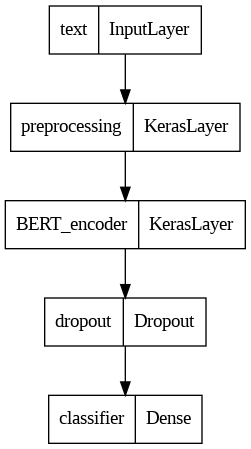

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
pip install "tf-models-official==2.13.*"


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 269.4/269.4 kB 16.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 20.3 MB/s eta 0:00:00
  Created wheel for pyyaml: filename=PyYAML-5.3.1-cp310-cp310-linux_x86_64.whl size=44635 sha256=6604acd8ce3f50cb40d9613738384354bbc576d04ba27e4aadf8e31820861c43
  Stored in directory: /root/.cache/pip/wheels/0b/a9/6a/d0a6981a8dbb698845178818642f72ce179f14336908c7df01
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=27375aae7d30d8103bfc346d0cbb929b3a863c01fdf2cd1fd0a3364c499cab15
  Stored in direc

### Train and evaluate the model

In [ ]:
from official.nlp import optimization
epochs = 30
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])



In [ ]:
history = classifier_model.fit(train_ds, validation_data=val_ds, epochs=epochs)


Epoch 1/5
1516/1516 [==============================] - 414s 269ms/step - loss: 1.1774 - accuracy: 0.4028 - val_loss: 1.1592 - val_accuracy: 0.4110
Epoch 2/5
1516/1516 [==============================] - 403s 266ms/step - loss: 1.1716 - accuracy: 0.4052 - val_loss: 1.1589 - val_accuracy: 0.4110
Epoch 3/5
1516/1516 [==============================] - 409s 270ms/step - loss: 1.1692 - accuracy: 0.4093 - val_loss: 1.1588 - val_accuracy: 0.4110
Epoch 4/5
1516/1516 [==============================] - 410s 270ms/step - loss: 1.1702 - accuracy: 0.4034 - val_loss: 1.1588 - val_accuracy: 0.4110
Epoch 5/5
1516/1516 [==============================] - 406s 268ms/step - loss: 1.1705 - accuracy: 0.4070 - val_loss: 1.1590 - val_accuracy: 0.4110


### Graph

(0.0, 2.0)

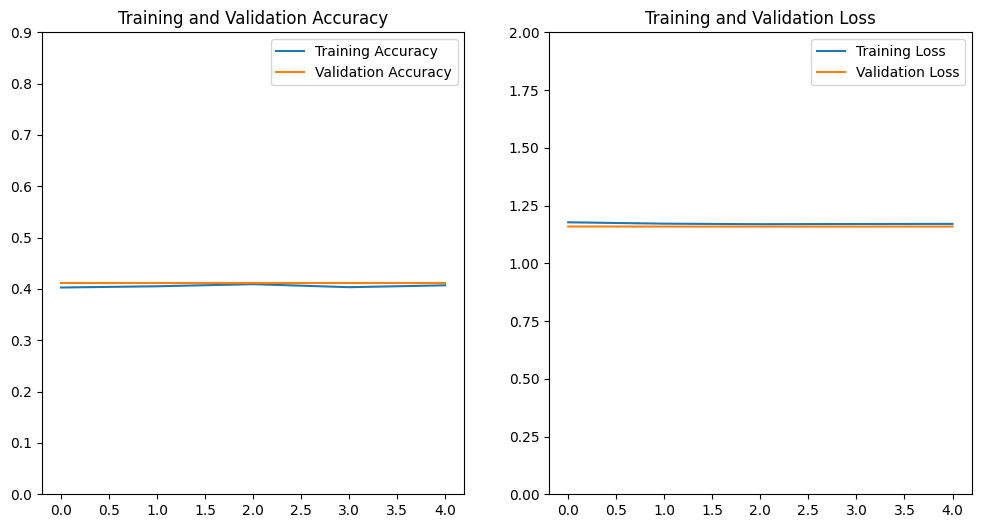

In [ ]:


acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.ylim(0,0.9)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim(0,2)

In [ ]:
classifier_model.evaluate(test_ds)

325/325 [==============================] - 44s 134ms/step - loss: 1.1690 - accuracy: 0.4164


[1.1690126657485962, 0.4164341390132904]

## Elmo

In [ ]:
text, sentiment = next(iter(train_ds))
text[:2], sentiment[:2]

(<tf.Tensor: shape=(2,), dtype=string, numpy=
 array([b'just finished my second exam only one more to go ',
        b'i was so much happier in prison ever since i came home mlife slowly fell apart im left with depression and severe dpdr i actually wish i was who i was in prison riddle me thatwtf'],
       dtype=object)>,
 <tf.Tensor: shape=(2, 4), dtype=float32, numpy=
 array([[1., 0., 0., 0.],
        [0., 0., 0., 1.]], dtype=float32)>)

In [ ]:
embedding = "https://tfhub.dev/google/elmo/3"
hub_layer = hub.KerasLayer(embedding, input_shape=[],
                           dtype=tf.string, trainable=False)
hub_layer(text[:2])


<tf.Tensor: shape=(2, 1024), dtype=float32, numpy=
array([[-0.04175044,  0.03717347,  0.19967361, ...,  0.25462112,
         0.01215486,  0.13489692],
       [ 0.08736485, -0.35710275,  0.0111554 , ..., -0.1214755 ,
         0.5738454 , -0.11753491]], dtype=float32)>

In [ ]:
def get_elmo_embeddings(text, sentiment):
  embeds = hub_layer(text)
  return (embeds, sentiment)

train_ds = train_ds.map(get_elmo_embeddings)
val_ds   = val_ds.map(get_elmo_embeddings)


In [ ]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 1024), dtype=tf.float32, name=None), TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))>

In [ ]:
text, sent = next(iter(train_ds))
text[:2]

<tf.Tensor: shape=(2, 1024), dtype=float32, numpy=
array([[-0.04175035,  0.03717357,  0.19967344, ...,  0.25462094,
         0.0121549 ,  0.13489696],
       [ 0.08736479, -0.3571027 ,  0.01115542, ..., -0.12147554,
         0.5738453 , -0.11753497]], dtype=float32)>

### Build the model

In [ ]:
inputs = tf.keras.layers.Input(shape=(1024))
x = tf.keras.layers.Dense(16, activation='relu')(inputs)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1024)]            0         
                                                                 
 dense (Dense)               (None, 16)                16400     
                                                                 
 dense_1 (Dense)             (None, 4)                 68        
                                                                 
Total params: 16468 (64.33 KB)
Trainable params: 16468 (64.33 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Compile and train

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds, validation_data=val_ds, epochs=30, batch_size=32)

Epoch 1/30
   1/1516 [..............................] - ETA: 64:01:11 - loss: 1.3024 - accuracy: 0.3438

KeyboardInterrupt: ignored

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.title('Training and Validation Accuracy')
plt.ylim(0,0.9)

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.ylim(0,2)